In [738]:
import os
os.environ['CASTLE_BACKEND'] = 'pytorch'

from collections import OrderedDict
import warnings

import numpy as np
import networkx as nx

from scipy import linalg 

from sklearn.linear_model import LinearRegression

import castle
from castle.common import GraphDAG
from castle.metrics import MetricsDAG
from castle.datasets import DAG, IIDSimulation 

from castle.algorithms import PC, GES
from castle.algorithms import ANMNonlinear, ICALiNGAM, DirectLiNGAM
from castle.algorithms import Notears, NotearsNonlinear, GOLEM

from castle.common.priori_knowledge import PrioriKnowledge

from castle.common.independence_tests import hsic_test

import matplotlib.pyplot as plt

In [2]:
COLORS = [
    '#00B0F0',
    '#FF0000',
    '#B0F000'
]

# Chapter 13 

**Causal discovery and machine learning – from assumptions to applications**



In [105]:
# Set random seed
SEED = 18
np.random.seed(SEED)

## Introduction to gCastle

### Synthetic data in gCastle

In [115]:
# Generate a scale-free adjacency matrix
adj_matrix = DAG.scale_free(
    n_nodes=10,
    n_edges=17,
    seed=SEED
)

In [253]:
adj_matrix

array([[0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 1., 0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 1., 0., 1., 0., 0., 0.]])

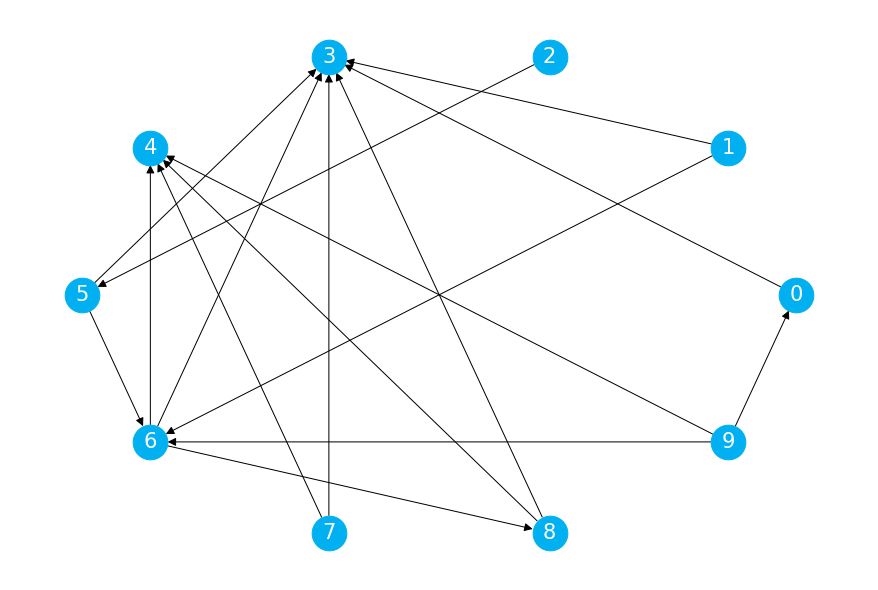

In [222]:
# Visualize the adjacency matrix
g = nx.DiGraph(adj_matrix)

plt.figure(figsize=(12, 8))
nx.draw(
    G=g,
    node_color=COLORS[0],
    node_size=1200,
    arrowsize=17,
    with_labels=True,
    font_color='white',
    font_size=21,
    pos=nx.circular_layout(g)
)

In [160]:
dataset = IIDSimulation(
    W=adj_matrix, 
    n=10000, 
    method='linear', 
    sem_type='gauss'
)

2023-03-23 10:06:53,753 - C:\Users\aleks\anaconda3\envs\causal_book_py38\lib\site-packages\castle\datasets\simulator.py[line:270] - INFO: Finished synthetic dataset


In [168]:
# Access the generated data
dataset.X

array([[-6.099e-01,  6.584e-01,  3.772e-01, ..., -5.272e-03,  2.729e+00,
        -4.699e-01],
       [-3.145e+00, -1.707e-02,  2.048e+00, ...,  2.742e-01,  5.032e-01,
        -5.107e-01],
       [-1.384e+00,  4.552e-01,  8.413e-01, ..., -5.719e-01,  2.219e+00,
        -9.003e-01],
       ...,
       [-1.629e+00, -5.249e-01, -3.018e-01, ..., -7.671e-01, -5.764e-01,
        -7.829e-01],
       [ 2.224e+00,  1.418e+00,  1.522e+00, ...,  1.842e+00,  6.779e+00,
         1.817e+00],
       [-1.204e-01, -3.057e+00,  7.546e-01, ..., -5.665e-01, -4.822e+00,
         3.326e-01]])

### Fitting your first causal discovery model

In [200]:
# Instantiate the model
pc = PC()

In [203]:
# Fit the model
pc.learn(dataset.X)

In [204]:
pred_dag = pc.causal_matrix
pred_dag

Tensor([[0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 1, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 1, 0, 0, 1, 0, 0, 0],
        [0, 0, 0, 1, 1, 0, 0, 0, 1, 0],
        [0, 0, 0, 1, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 1, 0, 0, 0, 0, 1],
        [1, 0, 0, 0, 1, 0, 0, 0, 0, 0]])

### Visualizing the model

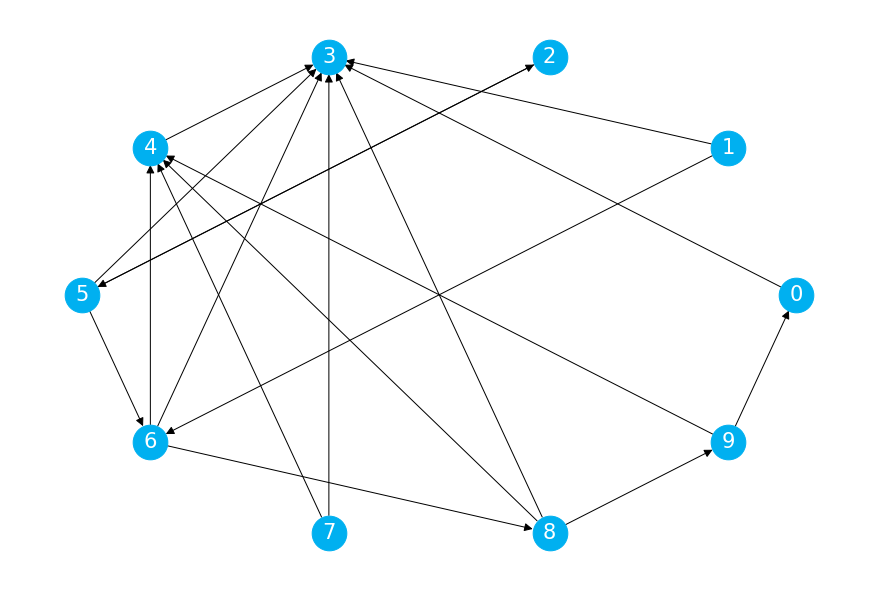

In [223]:
g_pred = nx.DiGraph(pred_dag)

plt.figure(figsize=(12, 8))
nx.draw(
    G=g_pred,
    node_color=COLORS[0],
    node_size=1200,
    arrowsize=17,
    with_labels=True,
    font_color='white',
    font_size=21,
    pos=nx.circular_layout(g)
)

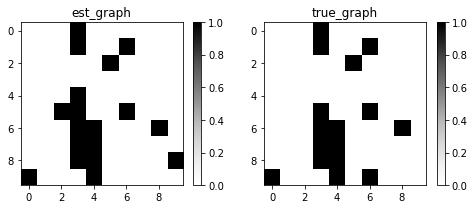

In [205]:
GraphDAG(
    est_dag=pred_dag, 
    true_dag=adj_matrix)

plt.show()

### Model evaluation metrics

In [228]:
metrics = MetricsDAG(
    B_est=pred_dag, 
    B_true=adj_matrix)

In [234]:
metrics.metrics['F1']

0.8824

In [247]:
metrics.metrics

{'fdr': 0.1176,
 'tpr': 0.9375,
 'fpr': 0.069,
 'shd': 3,
 'nnz': 17,
 'precision': 0.8333,
 'recall': 0.9375,
 'F1': 0.8824,
 'gscore': 0.75}

In [248]:
def get_n_undirected(g):
    
    total = 0
    
    for i in range(g.shape[0]):
        for j in range(g.shape[0]):
            if (g[i, j] == 1) and (g[i, j] == g[j, i]):
                total += .5
    
    return total

In [251]:
get_n_undirected(pred_dag)

1.0

In [264]:
np.tril(pred_dag)

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 1, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 1, 0, 0, 0, 0, 0]])

## Constraint-based causal discovery

In [290]:
# Build a DAG adj matrix
pc_dag = np.array([
    [0, 0, 1, 0],
    [0, 0, 1, 0],
    [0, 0, 0, 1],
    [0, 0, 0, 0]
])

In [295]:
# Generate data from this DAG
N = 1000

p = np.random.randn(N)
q = np.random.randn(N)

r = p + q + .1 * np.random.randn(N)
s = .7 * r + .1 * np.random.randn(N)

# To matrix
pc_dataset = np.vstack([p, q, r, s]).T

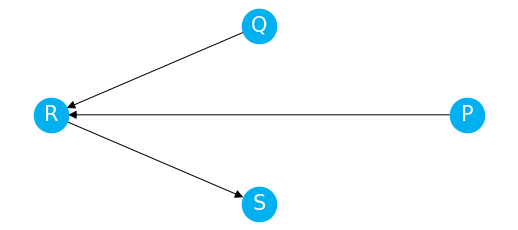

In [296]:
# Plot the original graph

# Get learned graph
true_graph = nx.DiGraph(pc_dag)

# Relabel the nodes
MAPPING = {k: v for k, v in zip(range(4), ['P', 'Q', 'R', 'S'])}
true_graph = nx.relabel_nodes(true_graph, MAPPING, copy=True)

plt.figure(figsize=(7, 3))
nx.draw(
    G=true_graph,
    node_color=COLORS[0],
    node_size=1200,
    arrowsize=17,
    with_labels=True,
    font_color='white',
    font_size=21,
    pos=nx.circular_layout(true_graph)
)

### PC

In [304]:
# Initialize PC
pc = PC()

# Fit 
pc.learn(pc_dataset)

# Display the learned matrix
pc.causal_matrix

Tensor([[0, 0, 1, 0],
        [0, 0, 1, 0],
        [0, 0, 0, 1],
        [0, 0, 0, 0]])

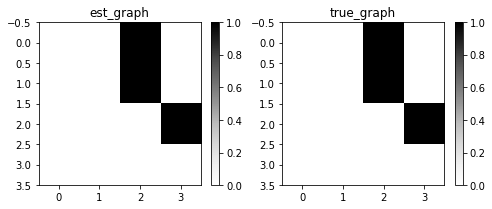

In [306]:
# Visualize
GraphDAG(
    est_dag=pc.causal_matrix, 
    true_dag=pc_dag)

plt.show()

In [307]:
# Get metrics
MetricsDAG(
    B_est=pc.causal_matrix,
    B_true=pc_dag
).metrics

{'fdr': 0.0,
 'tpr': 1.0,
 'fpr': 0.0,
 'shd': 0,
 'nnz': 3,
 'precision': 1.0,
 'recall': 1.0,
 'F1': 1.0,
 'gscore': 1.0}

### PC-stable

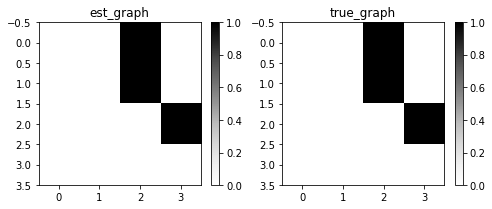

In [310]:
# PC-stable
pc_stable = PC(variant='stable')

# Fit 
pc_stable.learn(pc_dataset)

# Visualize
GraphDAG(
    est_dag=pc_stable.causal_matrix, 
    true_dag=pc_dag)

plt.show()

### PC-parallel

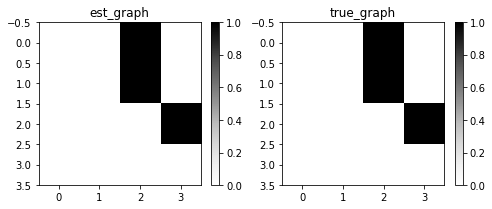

In [311]:
# PC-stable
pc_parallel = PC(variant='parallel')

# Fit 
pc_parallel.learn(pc_dataset)

# Visualize
GraphDAG(
    est_dag=pc_parallel.causal_matrix, 
    true_dag=pc_dag)

plt.show()

### PC with categorical data 

In [322]:
# Generate the data
a = np.random.binomial(4, .5, N)
b = np.random.binomial(4, .5, N)
c = ((a + b + np.random.normal(0, 1, N)) > 2).astype(int)

# To matrix
pc_cat_dataset = np.vstack([a, b, c]).T

In [335]:
pc_cat = PC(ci_test='chi2')

In [336]:
pc_cat.learn(pc_cat_dataset)

In [358]:
pc_cat.causal_matrix

Tensor([[0, 0, 1],
        [0, 0, 1],
        [0, 0, 0]])

### PC with alternative independence tests

In [338]:
from castle.common.independence_tests import CITest

In [353]:
pc_cat_alt = PC(ci_test=CITest.cressie_read)

In [354]:
pc_cat_alt.learn(pc_cat_dataset)

In [355]:
pc_cat_alt.causal_matrix

Tensor([[0, 0, 1],
        [0, 0, 1],
        [0, 0, 0]])

## Score-based causal discovery

In [379]:
# Instantiate GES
ges = GES(criterion='bic')

In [380]:
# Train
ges.learn(pc_dataset)

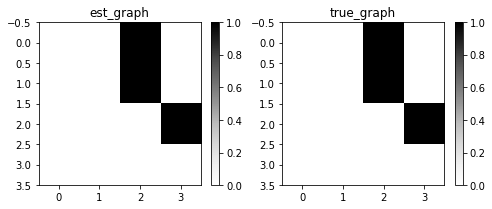

In [383]:
# Visualize
GraphDAG(
    est_dag=ges.causal_matrix, 
    true_dag=pc_dag)

plt.show()

## Function-based casual discovery

### ANM model (from scratch)

In [391]:
# Define helpers
from pygam import LinearGAM


class GAM:
    
    def __init__(self, n_splines):
        self.n_splines = n_splines
        
    def fit(self, x, y):
        # Check `x` dimensionality
        x = np.array(x)
        assert len(x.shape) == 2, f'`x` should be 2D array. Received {len(x.shape)} dimensional array.'
        
        # Fit the model
        self.model = LinearGAM(n_splines=self.n_splines).gridsearch(x, y) 
        
    def predict(self, x):
        return self.model.predict(x)

In [387]:
# Create data
x = np.random.randn(1000)
y = x**3 + np.random.randn(1000)

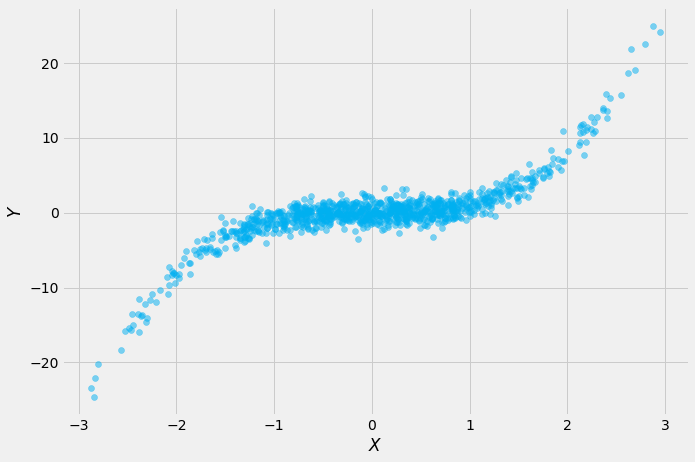

In [390]:
# Plot data
plt.style.use('fivethirtyeight')

plt.figure(figsize=(10, 7))

plt.scatter(x, y, alpha=.5, color=COLORS[0])

plt.xlabel('$X$')
plt.ylabel('$Y$')

plt.show()

In [401]:
# Define params
n_splines = 150

# Instantiate the models 
model_xy = GAM(n_splines=n_splines)
model_yx = GAM(n_splines=n_splines)

# Fit the models
model_xy.fit(x.reshape(-1, 1), y)
model_yx.fit(y.reshape(-1, 1), x)

# Generate predictions
y_pred = model_xy.predict(x.reshape(-1, 1))
x_pred = model_yx.predict(y.reshape(-1, 1))

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


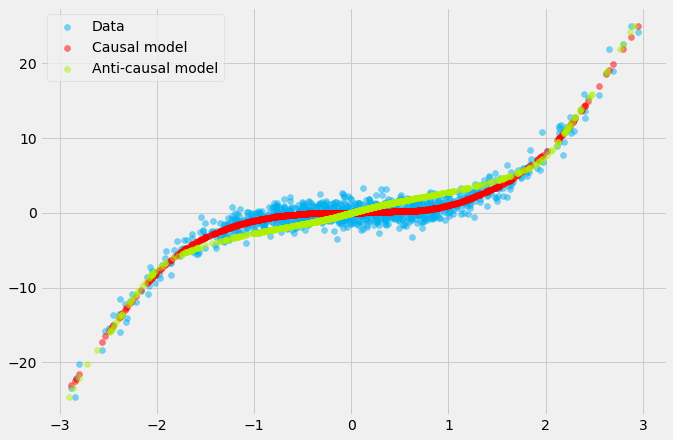

In [402]:
# Visualize the fitted model
plt.figure(figsize=(10, 7))
plt.scatter(x, y, alpha=.5, color=COLORS[0], label='Data')
plt.scatter(x, y_pred, alpha=.5, color=COLORS[1], label='Causal model')
plt.scatter(x_pred, y, alpha=.5, color=COLORS[2], label='Anti-causal model')
plt.legend()
plt.show()

In [403]:
# Get the residuals
residuals_xy = y - y_pred
residuals_yx = x - x_pred

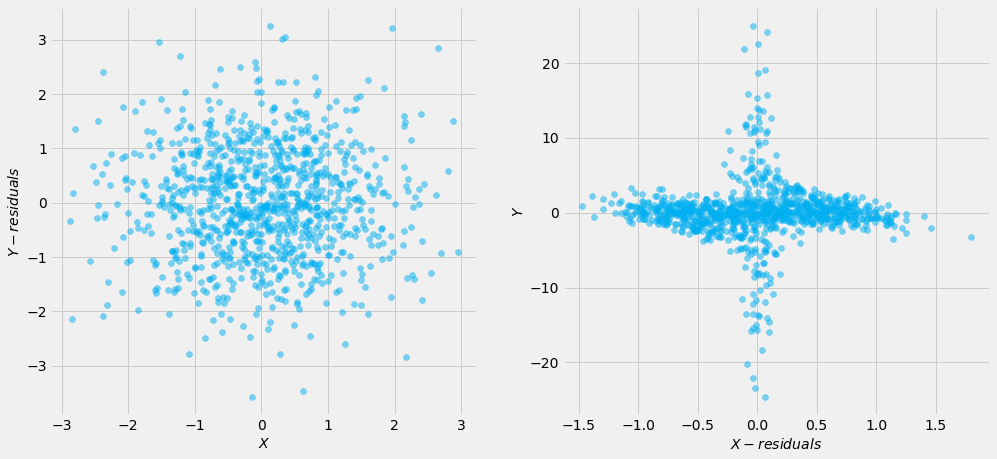

In [409]:
plt.figure(figsize=(15, 7))
plt.subplot(121)
plt.scatter(x, residuals_xy, alpha=.5, color=COLORS[0])
plt.xlabel('$X$', fontsize=14)
plt.ylabel('$Y-residuals$', fontsize=14)

plt.subplot(122)
plt.scatter(residuals_yx, y, alpha=.5, color=COLORS[0])
plt.xlabel('$X-residuals$', fontsize=14)
plt.ylabel('$Y$', fontsize=14)

plt.show()

In [442]:
# Compute HSIC
is_indep_xy = hsic_test(
    x = x.reshape(-1, 1), 
    y = residuals_xy.reshape(-1, 1),
    alpha=.05
) 

is_indep_yx = hsic_test(
    x = y.reshape(-1, 1), 
    y = residuals_yx.reshape(-1, 1),
    alpha=.05
)

In [443]:
is_indep_xy, is_indep_yx

(1, 0)

### ANM model (gCastle)

In [474]:
# Instantiate 
anm = ANMNonlinear(alpha=.1)

In [475]:
# Train
nonlinear_dataset = np.vstack([x, y]).T
anm.learn(nonlinear_dataset)

In [476]:
anm.causal_matrix

Tensor([[0., 0.],
        [0., 0.]])

The model fails to find the causal direction. The difference in the results might be caused by the fact that gCastle's implementation is based on Gaussian process regression rather than GAM.

## LiNGAM time!

In [503]:
# Generate data
SAMPLE_SIZE = 1000

x_gauss = np.random.normal(0, 1, SAMPLE_SIZE)
y_gauss = x_gauss + 0.3 * np.random.normal(0, 1, SAMPLE_SIZE)

x_ngauss = np.random.uniform(0, 1, SAMPLE_SIZE)
y_ngauss = x_ngauss + 0.3 * np.random.uniform(0, 1, SAMPLE_SIZE)

In [504]:
# Fit regressions 
results = {}

for name, v in zip(['Gaussian', 'non-Gaussian'], [(x_gauss, y_gauss), (x_ngauss, y_ngauss)]):
    
    for direction in ['y ~ x', 'x ~ y']:   
        
        predictor_idx = 0
        target_idx = 1
        
        if direction.startswith('x'):
            predictor_idx, target_idx = target_idx, predictor_idx

        key = f'{name} | {direction}'
        print(key)
        
        # Fit the model
        lr = LinearRegression()
        lr.fit(v[predictor_idx].reshape(-1, 1), v[target_idx])
        
        # Predict
        preds = lr.predict(v[predictor_idx].reshape(-1, 1))
        
        # Compute residuals
        residuals = v[target_idx] - preds
        
        results[key] = preds, residuals

Gaussian | y ~ x
Gaussian | x ~ y
non-Gaussian | y ~ x
non-Gaussian | x ~ y


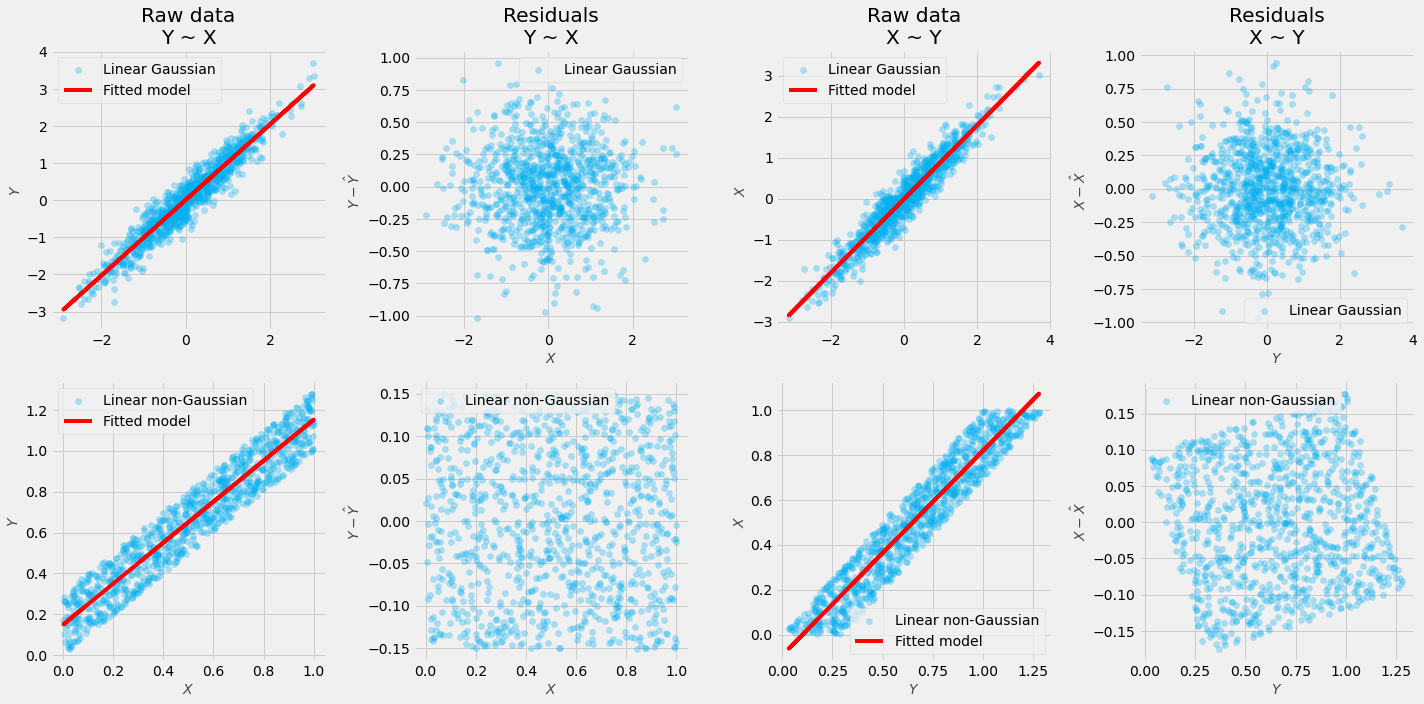

In [505]:
ALPHA = .3

# Plot the data
plt.figure(figsize=(20, 10))

# Plot X vs Y + regression lines
plt.subplot(241)
plt.scatter(x_gauss, y_gauss, label='Linear Gaussian', alpha=ALPHA, color=COLORS[0])
plt.plot(x_gauss, results['Gaussian | y ~ x'][0], color=COLORS[1], label='Fitted model')
plt.legend()
plt.ylabel('$Y$', alpha=.7, fontsize=14)
plt.title('Raw data\nY ~ X')

plt.subplot(245)
plt.scatter(x_ngauss, y_ngauss, label='Linear non-Gaussian', alpha=ALPHA, color=COLORS[0])
plt.plot(x_ngauss, results['non-Gaussian | y ~ x'][0], color=COLORS[1], label='Fitted model')
plt.xlabel('$X$', alpha=.7, fontsize=14)
plt.ylabel('$Y$', alpha=.7, fontsize=14)
plt.legend()


# Plot residuals Y ~ X
plt.subplot(242)
plt.scatter(x_gauss, results['Gaussian | y ~ x'][1], label='Linear Gaussian', color=COLORS[0], alpha=ALPHA)
plt.legend()
plt.ylabel('$Y - \hat{Y}$', alpha=.7, fontsize=14)
plt.xlabel('$X$', alpha=.7, fontsize=14)
plt.title('Residuals\nY ~ X')

plt.subplot(246)
plt.scatter(x_ngauss, results['non-Gaussian | y ~ x'][1], label='Linear non-Gaussian', color=COLORS[0], alpha=ALPHA)
plt.legend()
plt.ylabel('$Y - \hat{Y}$', alpha=.7, fontsize=14)
plt.xlabel('$X$', alpha=.7, fontsize=14)


# Plot Y vs X + regression lines
plt.subplot(243)
plt.scatter(y_gauss, x_gauss, label='Linear Gaussian', alpha=ALPHA, color=COLORS[0])
plt.plot(y_gauss, results['Gaussian | x ~ y'][0], color=COLORS[1], label='Fitted model')
plt.legend()
plt.ylabel('$X$', alpha=.7, fontsize=14)
plt.title('Raw data\nX ~ Y')

plt.subplot(247)
plt.scatter(y_ngauss, x_ngauss, label='Linear non-Gaussian', alpha=ALPHA, color=COLORS[0])
plt.plot(y_ngauss, results['non-Gaussian | x ~ y'][0], color=COLORS[1], label='Fitted model')
plt.xlabel('$Y$', alpha=.7, fontsize=14)
plt.ylabel('$X$', alpha=.7, fontsize=14)
plt.legend()


# Plot residuals X ~ Y
plt.subplot(244)
plt.scatter(y_gauss, results['Gaussian | x ~ y'][1], label='Linear Gaussian', color=COLORS[0], alpha=ALPHA)
plt.legend()
plt.xlabel('$Y$', alpha=.7, fontsize=14)
plt.ylabel('$X - \hat{X}$', alpha=.7, fontsize=14)
plt.title('Residuals\nX ~ Y')

plt.subplot(248)
plt.scatter(y_ngauss, results['non-Gaussian | x ~ y'][1], label='Linear non-Gaussian', color=COLORS[0], alpha=ALPHA)
plt.legend()
plt.xlabel('$Y$', alpha=.7, fontsize=14)
plt.ylabel('$X - \hat{X}$', alpha=.7, fontsize=14)

plt.tight_layout()
plt.show()

### LiNGAM in action

In [520]:
# Instantiate the model
lingam = ICALiNGAM(random_state=SEED)

# Fit
lingam.learn(pc_dataset)

C:\Users\aleks\anaconda3\envs\causal_book_py38\lib\site-packages\sklearn\decomposition\_fastica.py:494: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(
C:\Users\aleks\anaconda3\envs\causal_book_py38\lib\site-packages\sklearn\decomposition\_fastica.py:120: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
C:\Users\aleks\anaconda3\envs\causal_book_py38\lib\site-packages\sklearn\linear_model\_base.py:133: FutureWarning: The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipel

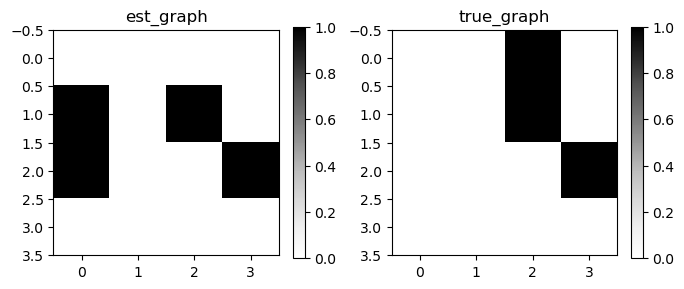

In [519]:
plt.style.use('default')

GraphDAG(
    est_dag=lingam.causal_matrix, 
    true_dag=pc_dag)

plt.show()

In [521]:
lingam.weight_causal_matrix

Tensor([[ 0.   ,  0.   ,  0.   ,  0.   ],
        [-0.987,  0.   ,  0.986,  0.   ],
        [ 0.989,  0.   ,  0.   ,  0.694],
        [ 0.   ,  0.   ,  0.   ,  0.   ]])

### Using legal data with LiNGAM

$$ \Large A := \epsilon_A$$

$$ \Large B := \epsilon_B$$

$$ \Large C := 1\times A + 1\times B + 0.1\times\epsilon_C$$

$$ \Large D := 0.7 \times C + 0.1\times\epsilon_D$$

In [527]:
N = 10000
a = np.random.uniform(0, 1, N)
b = np.random.uniform(3, 6, N)

c = a + b + .1 * np.random.uniform(-2, 0, N)
d = .7 * c + .1 * np.random.uniform(0, 1, N)

# To matrix
lingam_dataset = np.vstack([a, b, c, d]).T

In [530]:
# Instantiate the model
lingam = ICALiNGAM(random_state=SEED)

# Fit
lingam.learn(lingam_dataset)

C:\Users\aleks\anaconda3\envs\causal_book_py38\lib\site-packages\sklearn\decomposition\_fastica.py:494: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(
C:\Users\aleks\anaconda3\envs\causal_book_py38\lib\site-packages\sklearn\linear_model\_base.py:133: FutureWarning: The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  warnings.warn(
C:\Users\aleks\anaconda3\envs\causal_bo

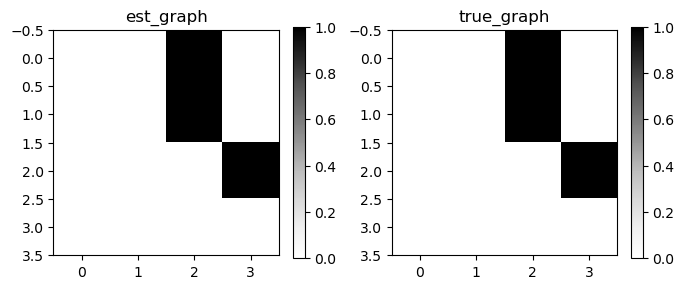

In [531]:
plt.style.use('default')

GraphDAG(
    est_dag=lingam.causal_matrix, 
    true_dag=pc_dag)

plt.show()

In [534]:
lingam.weight_causal_matrix

Tensor([[0.   , 0.   , 1.003, 0.   ],
        [0.   , 0.   , 0.999, 0.   ],
        [0.   , 0.   , 0.   , 0.7  ],
        [0.   , 0.   , 0.   , 0.   ]])

In [536]:
?ICALiNGAM

In [537]:
# Instantiate the model with 2000 iters
lingam = ICALiNGAM(
    max_iter=2000, 
    random_state=SEED
)

In [538]:
# Fit
lingam.learn(lingam_dataset)

C:\Users\aleks\anaconda3\envs\causal_book_py38\lib\site-packages\sklearn\decomposition\_fastica.py:494: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(
C:\Users\aleks\anaconda3\envs\causal_book_py38\lib\site-packages\sklearn\linear_model\_base.py:133: FutureWarning: The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  warnings.warn(
C:\Users\aleks\anaconda3\envs\causal_bo

In [539]:
lingam.weight_causal_matrix

Tensor([[0.   , 0.   , 1.003, 0.   ],
        [0.   , 0.   , 0.999, 0.   ],
        [0.   , 0.   , 0.   , 0.7  ],
        [0.   , 0.   , 0.   , 0.   ]])

### Get more direct!

In [557]:
# Instantiate the model
d_lingam = DirectLiNGAM()

# Fit
d_lingam.learn(lingam_dataset)

C:\Users\aleks\anaconda3\envs\causal_book_py38\lib\site-packages\sklearn\linear_model\_base.py:133: FutureWarning: The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  warnings.warn(
C:\Users\aleks\anaconda3\envs\causal_book_py38\lib\site-packages\sklearn\linear_model\_base.py:133: FutureWarning: The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, u

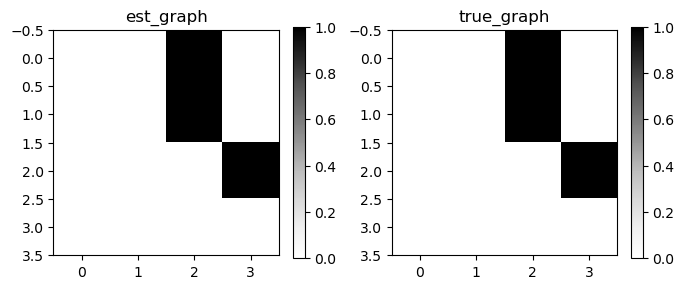

In [558]:
plt.style.use('default')

GraphDAG(
    est_dag=d_lingam.causal_matrix, 
    true_dag=pc_dag)

plt.show()

In [559]:
d_lingam.weight_causal_matrix

Tensor([[0.   , 0.   , 1.003, 0.   ],
        [0.   , 0.   , 0.999, 0.   ],
        [0.   , 0.   , 0.   , 0.7  ],
        [0.   , 0.   , 0.   , 0.   ]])

## Gradient-based causal discovery

In [599]:
def check_if_dag(adj_matrix):
    A = adj_matrix
    return np.trace(linalg.expm(A * A)) - A.shape[0] == 0

In [600]:
check_if_dag(pc_dag)

True

In [626]:
dcg = np.array([
    [0, 1, 0],
    [1, 0, 0],
    [0, 1, 0]
])

In [627]:
check_if_dag(dcg)

False

### The shootout

In [649]:
# Data simulation, simulate true causal dag and train_data.
true_dag = DAG.scale_free(n_nodes=10, n_edges=15, seed=SEED)


DATA_PARAMS = {
    'linearity': ['linear', 'nonlinear'], 
    'distribution': {
        'linear': ['gauss', 'exp'],
        'nonlinear': ['quadratic']
    }
}

datasets = {}

for linearity in DATA_PARAMS['linearity']:
    for distr in DATA_PARAMS['distribution'][linearity]:
        
        datasets[f'{linearity}_{distr}'] = IIDSimulation(
            W=true_dag, 
            n=2000, 
            method=linearity, 
            sem_type=distr)

2023-03-30 04:13:47,535 - C:\Users\aleks\anaconda3\envs\causal_book_py38\lib\site-packages\castle\datasets\simulator.py[line:270] - INFO: Finished synthetic dataset
2023-03-30 04:13:47,538 - C:\Users\aleks\anaconda3\envs\causal_book_py38\lib\site-packages\castle\datasets\simulator.py[line:270] - INFO: Finished synthetic dataset
2023-03-30 04:13:47,541 - C:\Users\aleks\anaconda3\envs\causal_book_py38\lib\site-packages\castle\datasets\simulator.py[line:270] - INFO: Finished synthetic dataset


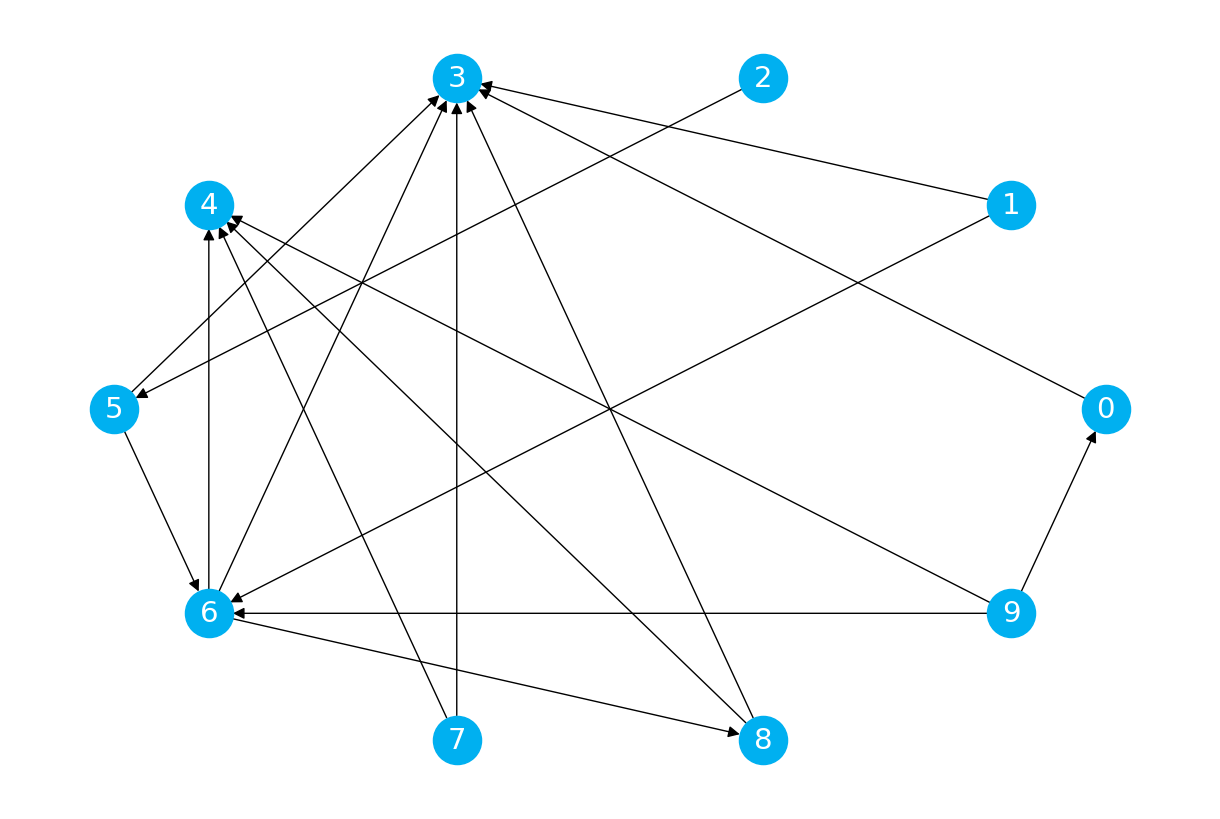

In [651]:
g = nx.DiGraph(true_dag)

plt.figure(figsize=(12, 8))
nx.draw(
    G=g,
    node_color=COLORS[0],
    node_size=1200,
    arrowsize=17,
    with_labels=True,
    font_color='white',
    font_size=21,
    pos=nx.circular_layout(g)
)

In [652]:
# Pick the methods
methods = OrderedDict({
    'PC': PC,
    'GES': GES,
    'LiNGAM': DirectLiNGAM,
    'Notears': NotearsNonlinear,
    'GOLEM': GOLEM
})

************* Current dataset: linear_gauss

Method: PC


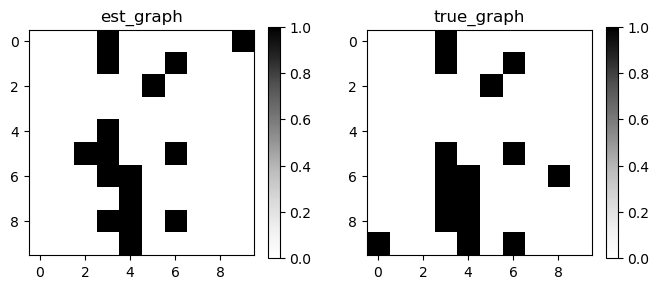

FDR: 0.2
Recall: 0.75
Precision: 0.75
F1 score: 0.75
SHD score: 5
No. of undir. edges: 1.0

-------------------------------------------------- 

Method: GES


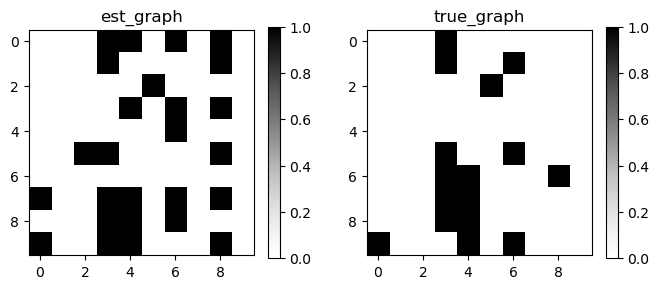

FDR: 0.5833
Recall: 0.625
Precision: 0.3846
F1 score: 0.4762
SHD score: 17
No. of undir. edges: 2.0

-------------------------------------------------- 

Method: LiNGAM


C:\Users\aleks\anaconda3\envs\causal_book_py38\lib\site-packages\sklearn\linear_model\_base.py:133: FutureWarning: The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  warnings.warn(
C:\Users\aleks\anaconda3\envs\causal_book_py38\lib\site-packages\sklearn\linear_model\_base.py:133: FutureWarning: The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, u

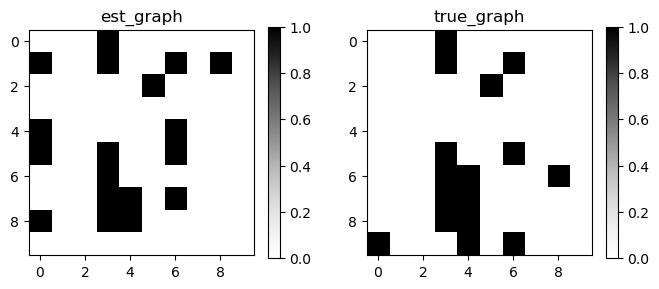

2023-03-30 04:17:06,564 - C:\Users\aleks\anaconda3\envs\causal_book_py38\lib\site-packages\castle\algorithms\gradient\notears\torch\nonlinear.py[line:135] - INFO: GPU is available.
2023-03-30 04:17:06,585 - C:\Users\aleks\anaconda3\envs\causal_book_py38\lib\site-packages\castle\algorithms\gradient\notears\torch\nonlinear.py[line:237] - INFO: [start]: n=2000, d=10, iter_=100, h_=1e-08, rho_=1e+16


FDR: 0.3889
Recall: 0.6875
Precision: 0.6111
F1 score: 0.6471
SHD score: 11
No. of undir. edges: 0

-------------------------------------------------- 

Method: Notears


2023-03-30 04:26:03,572 - C:\Users\aleks\anaconda3\envs\causal_book_py38\lib\site-packages\castle\algorithms\gradient\notears\torch\nonlinear.py[line:249] - INFO: FINISHED


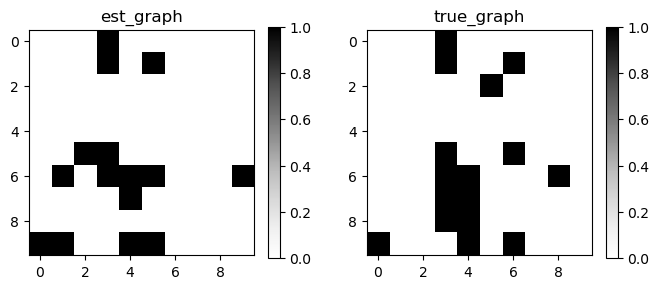

2023-03-30 04:26:03,900 - C:\Users\aleks\anaconda3\envs\causal_book_py38\lib\site-packages\castle\algorithms\gradient\notears\torch\golem.py[line:120] - INFO: GPU is available.
2023-03-30 04:26:03,920 - C:\Users\aleks\anaconda3\envs\causal_book_py38\lib\site-packages\castle\algorithms\gradient\notears\torch\golem.py[line:207] - INFO: Started training for 25000 iterations.
2023-03-30 04:26:03,951 - C:\Users\aleks\anaconda3\envs\causal_book_py38\lib\site-packages\castle\algorithms\gradient\notears\torch\golem.py[line:220] - INFO: [Iter 0] score=60.775, likelihood=60.775, h=0.0e+00


FDR: 0.4667
Recall: 0.5
Precision: 0.5333
F1 score: 0.5161
SHD score: 11
No. of undir. edges: 0

-------------------------------------------------- 

Method: GOLEM


2023-03-30 04:26:12,209 - C:\Users\aleks\anaconda3\envs\causal_book_py38\lib\site-packages\castle\algorithms\gradient\notears\torch\golem.py[line:220] - INFO: [Iter 5000] score=49.805, likelihood=49.489, h=1.6e-04
2023-03-30 04:26:20,499 - C:\Users\aleks\anaconda3\envs\causal_book_py38\lib\site-packages\castle\algorithms\gradient\notears\torch\golem.py[line:220] - INFO: [Iter 10000] score=49.804, likelihood=49.489, h=1.5e-04
2023-03-30 04:26:29,070 - C:\Users\aleks\anaconda3\envs\causal_book_py38\lib\site-packages\castle\algorithms\gradient\notears\torch\golem.py[line:220] - INFO: [Iter 15000] score=49.804, likelihood=49.489, h=1.6e-04
2023-03-30 04:26:37,522 - C:\Users\aleks\anaconda3\envs\causal_book_py38\lib\site-packages\castle\algorithms\gradient\notears\torch\golem.py[line:220] - INFO: [Iter 20000] score=49.804, likelihood=49.489, h=1.5e-04
2023-03-30 04:26:46,018 - C:\Users\aleks\anaconda3\envs\causal_book_py38\lib\site-packages\castle\algorithms\gradient\notears\torch\golem.py[

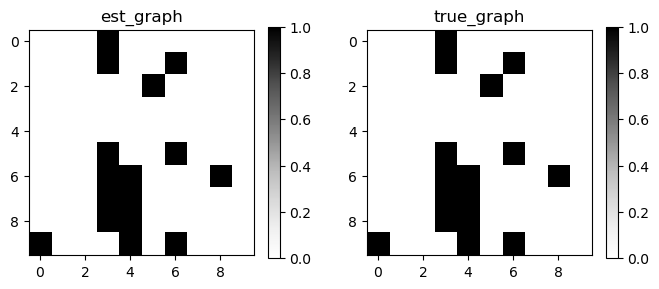

FDR: 0.0
Recall: 1.0
Precision: 1.0
F1 score: 1.0
SHD score: 0
No. of undir. edges: 0

-------------------------------------------------- 



************* Current dataset: linear_exp

Method: PC


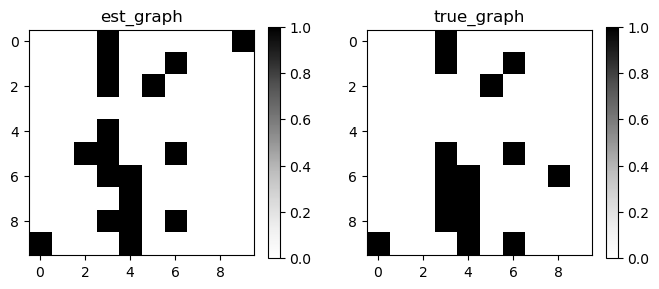

FDR: 0.1875
Recall: 0.8125
Precision: 0.7222
F1 score: 0.7647
SHD score: 5
No. of undir. edges: 2.0

-------------------------------------------------- 

Method: GES


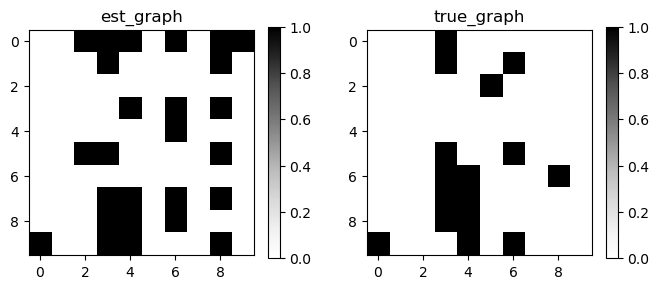

FDR: 0.625
Recall: 0.5625
Precision: 0.3462
F1 score: 0.4286
SHD score: 18
No. of undir. edges: 2.0

-------------------------------------------------- 

Method: LiNGAM


C:\Users\aleks\anaconda3\envs\causal_book_py38\lib\site-packages\sklearn\linear_model\_base.py:133: FutureWarning: The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  warnings.warn(
C:\Users\aleks\anaconda3\envs\causal_book_py38\lib\site-packages\sklearn\linear_model\_base.py:133: FutureWarning: The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, u

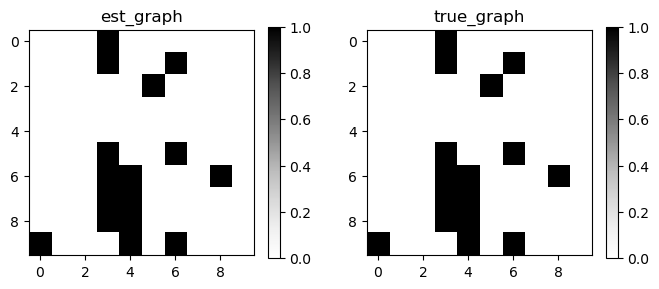

2023-03-30 04:26:49,881 - C:\Users\aleks\anaconda3\envs\causal_book_py38\lib\site-packages\castle\algorithms\gradient\notears\torch\nonlinear.py[line:135] - INFO: GPU is available.
2023-03-30 04:26:49,885 - C:\Users\aleks\anaconda3\envs\causal_book_py38\lib\site-packages\castle\algorithms\gradient\notears\torch\nonlinear.py[line:237] - INFO: [start]: n=2000, d=10, iter_=100, h_=1e-08, rho_=1e+16


FDR: 0.0
Recall: 1.0
Precision: 1.0
F1 score: 1.0
SHD score: 0
No. of undir. edges: 0

-------------------------------------------------- 

Method: Notears


2023-03-30 04:38:36,136 - C:\Users\aleks\anaconda3\envs\causal_book_py38\lib\site-packages\castle\algorithms\gradient\notears\torch\nonlinear.py[line:249] - INFO: FINISHED


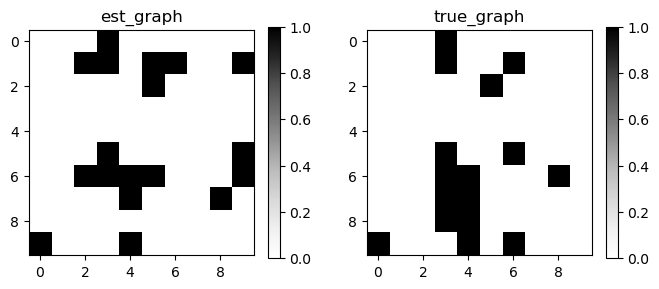

2023-03-30 04:38:36,455 - C:\Users\aleks\anaconda3\envs\causal_book_py38\lib\site-packages\castle\algorithms\gradient\notears\torch\golem.py[line:120] - INFO: GPU is available.
2023-03-30 04:38:36,466 - C:\Users\aleks\anaconda3\envs\causal_book_py38\lib\site-packages\castle\algorithms\gradient\notears\torch\golem.py[line:207] - INFO: Started training for 25000 iterations.
2023-03-30 04:38:36,468 - C:\Users\aleks\anaconda3\envs\causal_book_py38\lib\site-packages\castle\algorithms\gradient\notears\torch\golem.py[line:220] - INFO: [Iter 0] score=70.581, likelihood=70.581, h=0.0e+00


FDR: 0.4444
Recall: 0.625
Precision: 0.5556
F1 score: 0.5882
SHD score: 12
No. of undir. edges: 0

-------------------------------------------------- 

Method: GOLEM


2023-03-30 04:38:44,374 - C:\Users\aleks\anaconda3\envs\causal_book_py38\lib\site-packages\castle\algorithms\gradient\notears\torch\golem.py[line:220] - INFO: [Iter 5000] score=51.017, likelihood=50.664, h=2.2e-03
2023-03-30 04:38:52,434 - C:\Users\aleks\anaconda3\envs\causal_book_py38\lib\site-packages\castle\algorithms\gradient\notears\torch\golem.py[line:220] - INFO: [Iter 10000] score=51.013, likelihood=50.660, h=2.1e-03
2023-03-30 04:39:00,738 - C:\Users\aleks\anaconda3\envs\causal_book_py38\lib\site-packages\castle\algorithms\gradient\notears\torch\golem.py[line:220] - INFO: [Iter 15000] score=51.013, likelihood=50.660, h=2.2e-03
2023-03-30 04:39:09,299 - C:\Users\aleks\anaconda3\envs\causal_book_py38\lib\site-packages\castle\algorithms\gradient\notears\torch\golem.py[line:220] - INFO: [Iter 20000] score=51.013, likelihood=50.660, h=2.2e-03
2023-03-30 04:39:17,512 - C:\Users\aleks\anaconda3\envs\causal_book_py38\lib\site-packages\castle\algorithms\gradient\notears\torch\golem.py[

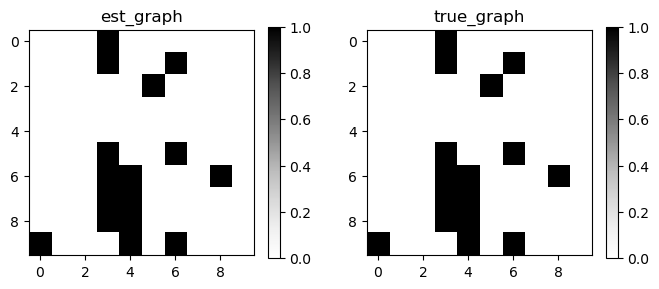

FDR: 0.0
Recall: 1.0
Precision: 1.0
F1 score: 1.0
SHD score: 0
No. of undir. edges: 0

-------------------------------------------------- 



************* Current dataset: nonlinear_quadratic

Method: PC


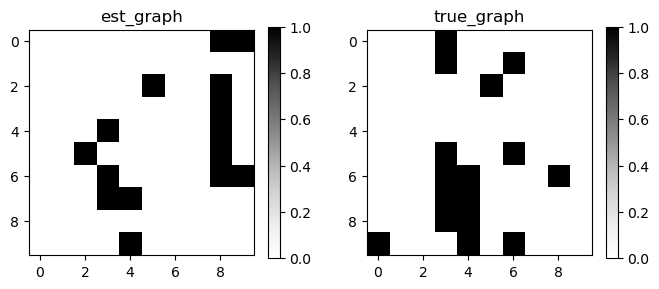

FDR: 0.5714
Recall: 0.375
Precision: 0.4
F1 score: 0.3871
SHD score: 14
No. of undir. edges: 1.0

-------------------------------------------------- 

Method: GES


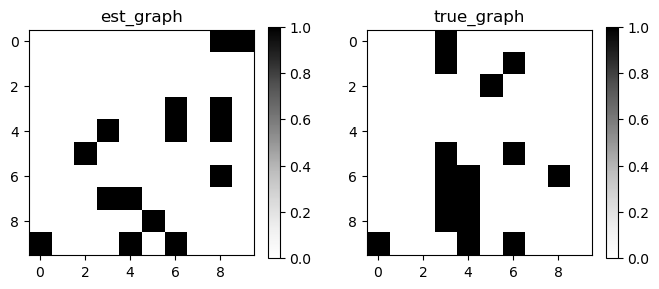

FDR: 0.5714
Recall: 0.375
Precision: 0.4
F1 score: 0.3871
SHD score: 13
No. of undir. edges: 1.0

-------------------------------------------------- 

Method: LiNGAM


C:\Users\aleks\anaconda3\envs\causal_book_py38\lib\site-packages\sklearn\linear_model\_base.py:133: FutureWarning: The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  warnings.warn(
C:\Users\aleks\anaconda3\envs\causal_book_py38\lib\site-packages\sklearn\linear_model\_base.py:133: FutureWarning: The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, u

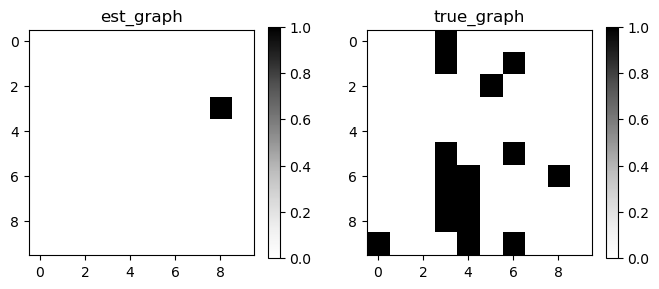

C:\Users\aleks\anaconda3\envs\causal_book_py38\lib\site-packages\castle\metrics\evaluation.py:226: RuntimeWarning: invalid value encountered in double_scalars
  F1 = 2*(recall*precision)/(recall+precision)
2023-03-30 04:39:20,165 - C:\Users\aleks\anaconda3\envs\causal_book_py38\lib\site-packages\castle\algorithms\gradient\notears\torch\nonlinear.py[line:135] - INFO: GPU is available.
2023-03-30 04:39:20,171 - C:\Users\aleks\anaconda3\envs\causal_book_py38\lib\site-packages\castle\algorithms\gradient\notears\torch\nonlinear.py[line:237] - INFO: [start]: n=2000, d=10, iter_=100, h_=1e-08, rho_=1e+16


FDR: 1.0
Recall: 0.0
Precision: 0.0
F1 score: nan
SHD score: 16
No. of undir. edges: 0

-------------------------------------------------- 

Method: Notears


2023-03-30 04:40:47,669 - C:\Users\aleks\anaconda3\envs\causal_book_py38\lib\site-packages\castle\algorithms\gradient\notears\torch\nonlinear.py[line:249] - INFO: FINISHED


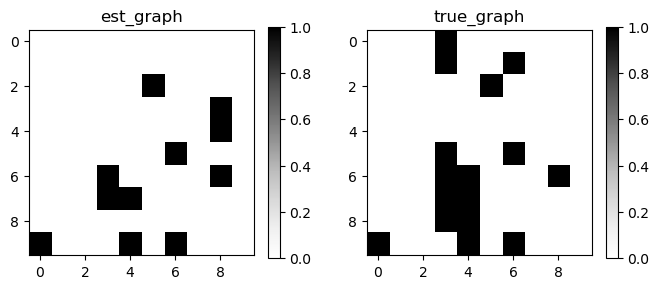

2023-03-30 04:40:48,002 - C:\Users\aleks\anaconda3\envs\causal_book_py38\lib\site-packages\castle\algorithms\gradient\notears\torch\golem.py[line:120] - INFO: GPU is available.
2023-03-30 04:40:48,013 - C:\Users\aleks\anaconda3\envs\causal_book_py38\lib\site-packages\castle\algorithms\gradient\notears\torch\golem.py[line:207] - INFO: Started training for 25000 iterations.
2023-03-30 04:40:48,015 - C:\Users\aleks\anaconda3\envs\causal_book_py38\lib\site-packages\castle\algorithms\gradient\notears\torch\golem.py[line:220] - INFO: [Iter 0] score=55.103, likelihood=55.103, h=0.0e+00


FDR: 0.1818
Recall: 0.5625
Precision: 0.8182
F1 score: 0.6667
SHD score: 7
No. of undir. edges: 0

-------------------------------------------------- 

Method: GOLEM


2023-03-30 04:40:56,179 - C:\Users\aleks\anaconda3\envs\causal_book_py38\lib\site-packages\castle\algorithms\gradient\notears\torch\golem.py[line:220] - INFO: [Iter 5000] score=53.118, likelihood=52.721, h=2.1e-02
2023-03-30 04:41:04,373 - C:\Users\aleks\anaconda3\envs\causal_book_py38\lib\site-packages\castle\algorithms\gradient\notears\torch\golem.py[line:220] - INFO: [Iter 10000] score=53.118, likelihood=52.721, h=2.1e-02
2023-03-30 04:41:13,287 - C:\Users\aleks\anaconda3\envs\causal_book_py38\lib\site-packages\castle\algorithms\gradient\notears\torch\golem.py[line:220] - INFO: [Iter 15000] score=53.118, likelihood=52.721, h=2.1e-02
2023-03-30 04:41:22,150 - C:\Users\aleks\anaconda3\envs\causal_book_py38\lib\site-packages\castle\algorithms\gradient\notears\torch\golem.py[line:220] - INFO: [Iter 20000] score=53.118, likelihood=52.721, h=2.1e-02
2023-03-30 04:41:31,365 - C:\Users\aleks\anaconda3\envs\causal_book_py38\lib\site-packages\castle\algorithms\gradient\notears\torch\golem.py[

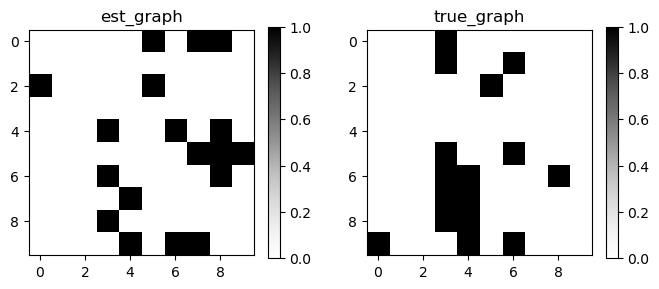

FDR: 0.6111
Recall: 0.4375
Precision: 0.3889
F1 score: 0.4118
SHD score: 18
No. of undir. edges: 0

-------------------------------------------------- 





In [653]:
results = {}

for k, dataset in datasets.items():
    print(f'************* Current dataset: {k}\n')
    X = dataset.X
    
    results[dataset] = {}
    
    for method in methods:

        print(f'Method: {method}')

        # Fit the model
        if method == 'GOLEM':
            model = methods[method](num_iter=2.5e4)
        else:
            model = methods[method]()
        
        # Fit the model
        model.learn(X)
        
        # Get the DAG
        pred_dag = model.causal_matrix
              
        # Get n undir edges
        n_undir = get_n_undirected(pred_dag)

        # Plot results
        GraphDAG(pred_dag, true_dag, 'result')

        mt = MetricsDAG(pred_dag, true_dag)
        print(f'FDR: {mt.metrics["fdr"]}')
        print(f'Recall: {mt.metrics["recall"]}')
        print(f'Precision: {mt.metrics["precision"]}')
        print(f'F1 score: {mt.metrics["F1"]}')
        print(f'SHD score: {mt.metrics["shd"]}')
        print(f'No. of undir. edges: {n_undir}\n')
        print('-' * 50, '\n')

        results[dataset][method] = pred_dag      
            
    print('\n')   

## Encoding expert knowledge

### `PC`

In [760]:
# Instantiate and encode priori knowledge
priori_knowledge = PrioriKnowledge(n_nodes=10)

# Add required & forbidden edges
priori_knowledge.add_required_edges([(7, 3)])
priori_knowledge.add_forbidden_edges([(0, 9), (8, 6)])

In [764]:
# Instantiate the model with expert knowledge
pc_priori = PC(priori_knowledge=priori_knowledge)

# Learn
pc_priori.learn(datasets['linear_gauss'].X)

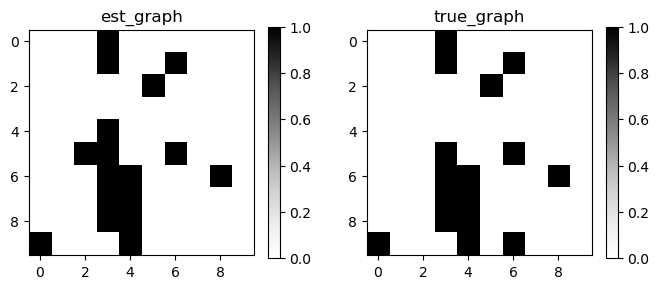

In [765]:
# Plot the results
plt.style.use('default')

GraphDAG(
    est_dag=pc_priori.causal_matrix, 
    true_dag=true_dag)

plt.show()

In [766]:
# Compute metrics
mt = MetricsDAG(pc_priori.causal_matrix, true_dag)
print(f'FDR: {mt.metrics["fdr"]}')
print(f'Recall: {mt.metrics["recall"]}')
print(f'Precision: {mt.metrics["precision"]}')
print(f'F1 score: {mt.metrics["F1"]}')
print(f'SHD score: {mt.metrics["shd"]}')
print(f'No. of undir. edges: {n_undir}\n')

FDR: 0.0625
Recall: 0.9375
Precision: 0.8824
F1 score: 0.9091
SHD score: 2
No. of undir. edges: 0

